In [16]:
# Prepare gym for agent
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Getting enviroment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [17]:
print(env.action_space)
env.reset()
state, reward, done, info = env.step(env.action_space.sample())
print(state)

Discrete(2)
[ 0.04407717 -0.19611707  0.02462632  0.34364596]


Two possible actions [0,1]
State descrived by [position of cart, velocity of cart, angle of pole, rotation rate of pole].

Neural Network implementation to approximate the Q action value function.

## Experience Replay memory implementation.

In [18]:
from collections import deque
class Memory_exp_replay:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add_timestep(self, env_reaction):
        # St, At, Rt1, St1.
        self.buffer.append(env_reaction)
        
    def sample_random(self, sample_size, debug=False):
        # Replace=False, important so it doesn't repeat a sample on the batch
        indexs = np.random.choice(a=np.arange(len(self.buffer)), size=sample_size, replace=False) 
        if debug:
            print(indexs)
        states = list()
        actions = list()
        rewards = list()
        next_states = list()
        for index in indexs:
            states.append(self.buffer[index][0])
            actions.append(self.buffer[index][1])
            rewards.append(self.buffer[index][2])
            next_states.append(self.buffer[index][3])
        batch = [np.array(states), np.array(actions), np.array(rewards), np.array(next_states)]
        return batch

Testing out the Memory Buffer.

In [19]:
# Initliaze memory
def populate_memory(env, exp_replay_memory, batch_size_Q, debug=False):
    if debug: 
        print('Order of enviroment reactions')
    content = 0
    s_t1 = env.reset()
    while content < batch_size_Q:
        s_t = s_t1 
        a_t = env.action_space.sample()
        s_t1, r_t1, done, info = env.step(a_t)
        if done:
            s_t1 = np.zeros(s_t.shape)
            if debug: 
                print(content, s_t)
            exp_replay_memory.add_timestep((s_t, a_t, r_t1, s_t1))
            s_t = env.reset()
        else:
            if debug: 
                print(content, s_t)
            exp_replay_memory.add_timestep((s_t, a_t, r_t1, s_t1))
        content += 1
    return exp_replay_memory

memory_size = 100000
batch_size_Q = 20

# Intantiate memory and populate
exp_replay = Memory_exp_replay(memory_size)
exp_replay = populate_memory(env, exp_replay, batch_size_Q, debug=True)

print('Random sample from Memory Buffer')
states, actions, rewards, next_states = exp_replay.sample_random(2, debug=True)
for state in states:
    print(state)

Order of enviroment reactions
0 [ 0.00918992 -0.0223798   0.04928281  0.01554019]
1 [ 0.00874232 -0.21817261  0.04959362  0.32335611]
2 [ 0.00437887 -0.02379064  0.05606074  0.04671619]
3 [ 0.00390305  0.17048449  0.05699506 -0.22776548]
4 [ 0.00731274  0.36474758  0.05243975 -0.50193947]
5 [ 0.0146077   0.55909266  0.04240096 -0.77764613]
6 [ 0.02578955  0.36341408  0.02684804 -0.47192992]
7 [ 0.03305783  0.55814674  0.01740944 -0.75603127]
8 [ 0.04422077  0.3627892   0.00228882 -0.45792125]
9 [ 0.05147655  0.55787872 -0.00686961 -0.74988185]
10 [ 0.06263412  0.36285219 -0.02186724 -0.45936861]
11 [ 0.06989117  0.55827632 -0.03105462 -0.75886316]
12 [ 0.08105669  0.75381211 -0.04623188 -1.06115403]
13 [ 0.09613294  0.55933187 -0.06745496 -0.7833327 ]
14 [ 0.10731957  0.75531279 -0.08312161 -1.09645225]
15 [ 0.12242583  0.95142505 -0.10505066 -1.41401461]
16 [ 0.14145433  0.75774989 -0.13333095 -1.15593152]
17 [ 0.15660933  0.56459399 -0.15644958 -0.90785243]
18 [ 0.16790121  0.7614482

### Memory working well.

## Q Value Neural Network inference.

In [20]:
# Defining NN for the action value function approximation.
class NN_Q_approx:
    def __init__(self, learning_rate, hidden_size, state_space, action_space, name):
        self.learning_rate = learning_rate
        self.state_space = state_space
        self.action_space = action_space
        self.name = name
        with tf.variable_scope(self.name):
            self.inputs = tf.placeholder(dtype=tf.float32, shape=[None, self.state_space], name='state_input')
            
            # Placeholder to choose the action value for the action done.
            self.actions = tf.placeholder(dtype=tf.int32, shape=[None], name='action_output')
            actions_oh = tf.one_hot(self.actions, self.action_space)
            
            self.target_Q = tf.placeholder(dtype=tf.float32, shape= [None], name='target_Q')
            
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs, hidden_size, scope='fc1')
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size, scope='fc2')
#             self.fc3 = tf.contrib.layers.fully_connected(self.fc2, hidden_size, scope='fc3')
            self.output = tf.contrib.layers.fully_connected(self.fc2, self.action_space, activation_fn=None, scope='output')
            # Until here for action value prediction.
            
            # Q size [m, action_space] -> sum, size [m, 1]
            self.Q = tf.reduce_sum(tf.multiply(self.output, actions_oh), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.Q - self.target_Q))
            self.opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)     
            

Defining Epislon-Greedy Policy and Weigth update for the Target NN.

In [21]:
def epsilon_greedy(epsilon, q_value):
    probabilities = np.ones(q_value[0].shape)*epsilon/action_space
    probabilities[np.argmax(q_value[0])] = 1 - epsilon + (epsilon/action_space)
    action = np.random.choice(a=np.arange(action_space), size=1, p=probabilities)
    return int(action)


# If I don't assign the value and variable relationship before each iteration, it is incredibly slow.
# Assigning the relationship of the graph and just updating the value is much faster.
def relate_variables_NN(Q_NN_target, Q_NN_grad):
    assigns = list()
    Q_NN_grad_variables =[v for v in tf.trainable_variables() if Q_NN_grad.name in v.name]
    Q_NN_target_variables =[v for v in tf.trainable_variables() if Q_NN_target.name in v.name]
#     Q_NN_grad_values = sess.run(Q_NN_grad_variables)
    for ind_g, var in enumerate(Q_NN_grad_variables):
        for var_target in Q_NN_target_variables:
            if var_target.name.replace(Q_NN_target.name,Q_NN_grad.name)==var.name:
#                 assigns.append(tf.assign(var_target, Q_NN_grad_values[ind_g]))
                assigns.append(tf.assign(var_target, var.value()))
                break

    return assigns

def update_values_sess(sess, assigns):
    for assign_oper in assigns:
        sess.run(assign_oper)

Defining parameters for neural network and replay memory, to test out how NN performs to learn Q values.

In [22]:
## NN parameters.
learning_rate_nn = 0.001
hidden_size = 64
state_space = len(state)
action_space = env.action_space.n

# Memory parameters.
memory_size = 100000
batch_size_Q = 128

# Training parameters.
max_episodes = 3000
max_steps_episode = 200
gamma = 1

# Exploration parameters
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01

# Update Target NN weights every X steps.
update_nn_target = 5

Code to run training.

In [24]:
def train_agent(path_to_model):
    
    # Intantiate memory and populate
    exp_replay = Memory_exp_replay(memory_size)
    exp_replay = populate_memory(env, exp_replay, batch_size_Q)

    # Initiliaze TensorFlow Graph
    tf.reset_default_graph()
    Q_NN_target = NN_Q_approx(learning_rate=learning_rate_nn, hidden_size=hidden_size, state_space=state_space, action_space=action_space, name='Q_action_target')
    Q_NN_grad = NN_Q_approx(learning_rate=learning_rate_nn, hidden_size=hidden_size, state_space=state_space, action_space=action_space, name='Q_action_grad')
    assigns = relate_variables_NN(Q_NN_target, Q_NN_grad)

    training_rewards = list()
    training_loss = list()
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        # Initializa variables 
        sess.run(tf.global_variables_initializer())
        ep_iter = 0

        for i in range(1, max_episodes+1):
            # Intiliazing variables for episode.
            s_t1 = env.reset()
            time_step = 0
            episode_reward = 0

            while time_step < max_steps_episode:
                # Watch it learn.
#                 env.render()

                s_t = s_t1
                # Controling epsilon.
                ep_iter += 1
                epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*i) 

                # Find Q Values and select action under E-greedy policy.
                q_values = sess.run(Q_NN_grad.output, feed_dict={Q_NN_grad.inputs:np.array(s_t).reshape((1, -1))})
                a_t = epsilon_greedy(epsilon, q_values)

                s_t1, r_t1, done, info = env.step(a_t)

                episode_reward += gamma*r_t1
                time_step += 1

                if done:
                    # Terminating episode
                    time_step = max_steps_episode
                    s_t1 = np.zeros(state_space)
                    # Update memory
                    exp_replay.add_timestep((s_t, a_t, r_t1, s_t1))

                    # Tracking information
                    training_rewards.append((i, episode_reward))
                    training_loss.append((i, loss))
                    print('Episode: {}'.format(i),


                          'Total reward: {:.4f}'.format(episode_reward),
                          'Training loss: {:.4f}'.format(loss),
                          'Epsilon: {:.4f}'.format(epsilon))
                else:
                    # Update memory
                    exp_replay.add_timestep((s_t, a_t, r_t1, s_t1))

                # Train network.
                states, actions, rewards, next_states = exp_replay.sample_random(batch_size_Q)

                estimated_Qs = sess.run(Q_NN_target.output, feed_dict = {Q_NN_target.inputs:next_states})
                action_Qs = sess.run(Q_NN_grad.output, feed_dict = {Q_NN_grad.inputs:next_states})
                found_initial = (next_states == np.zeros(states[0].shape)).all(axis=1)
                estimated_Qs[found_initial] = np.zeros(estimated_Qs[0].shape)
                action_Qs[found_initial] = np.zeros(estimated_Qs[0].shape)

                actions_t = (action_Qs==np.amax(action_Qs, axis=1, keepdims=True))
                target_Qs = rewards + gamma*np.max(estimated_Qs*actions_t, axis=1)

                feed_dict = {Q_NN_grad.inputs:states, Q_NN_grad.actions:actions, Q_NN_grad.target_Q: target_Qs}
                loss, _ = sess.run([Q_NN_grad.loss, Q_NN_grad.opt], feed_dict)

                if ep_iter%update_nn_target==0:
                    update_values_sess(sess, assigns)

                if (len(training_rewards)>=100) and (np.array(training_rewards[-100:])>= 195).all():
                    print('Gym solved!')
                    print('Final Episode:', i)
                    save_path = saver.save(sess, path_to_model)
                    print('Saved model: %s' % path_to_model)
                    return training_loss, training_rewards
    
    return training_loss, training_rewards

model_path = './ddqlearning_cartpole_vo.h5'

training_loss, training_rewards = train_agent(model_path)

Episode: 1 Total reward: 19.0000 Training loss: 0.9562 Epsilon: 0.9901
Episode: 2 Total reward: 30.0000 Training loss: 1.4579 Epsilon: 0.9804
Episode: 3 Total reward: 47.0000 Training loss: 6.5672 Epsilon: 0.9707
Episode: 4 Total reward: 22.0000 Training loss: 40.5953 Epsilon: 0.9612
Episode: 5 Total reward: 11.0000 Training loss: 55.2003 Epsilon: 0.9517
Episode: 6 Total reward: 16.0000 Training loss: 83.8855 Epsilon: 0.9423
Episode: 7 Total reward: 31.0000 Training loss: 237.1657 Epsilon: 0.9331
Episode: 8 Total reward: 21.0000 Training loss: 664.2860 Epsilon: 0.9239
Episode: 9 Total reward: 27.0000 Training loss: 757.8290 Epsilon: 0.9148
Episode: 10 Total reward: 20.0000 Training loss: 5351.3242 Epsilon: 0.9058
Episode: 11 Total reward: 11.0000 Training loss: 10220.6934 Epsilon: 0.8969
Episode: 12 Total reward: 16.0000 Training loss: 11762.7510 Epsilon: 0.8881
Episode: 13 Total reward: 11.0000 Training loss: 13095.7529 Epsilon: 0.8793
Episode: 14 Total reward: 36.0000 Training loss: 

Episode: 111 Total reward: 43.0000 Training loss: 277.7210 Epsilon: 0.3363
Episode: 112 Total reward: 85.0000 Training loss: 553.5406 Epsilon: 0.3330
Episode: 113 Total reward: 66.0000 Training loss: 246.9668 Epsilon: 0.3298
Episode: 114 Total reward: 61.0000 Training loss: 174.6095 Epsilon: 0.3266
Episode: 115 Total reward: 37.0000 Training loss: 755.2308 Epsilon: 0.3235
Episode: 116 Total reward: 38.0000 Training loss: 499.4123 Epsilon: 0.3204
Episode: 117 Total reward: 53.0000 Training loss: 136.1291 Epsilon: 0.3173
Episode: 118 Total reward: 54.0000 Training loss: 566.4106 Epsilon: 0.3142
Episode: 119 Total reward: 44.0000 Training loss: 465.4877 Epsilon: 0.3112
Episode: 120 Total reward: 58.0000 Training loss: 700.1663 Epsilon: 0.3082
Episode: 121 Total reward: 17.0000 Training loss: 514.4642 Epsilon: 0.3052
Episode: 122 Total reward: 84.0000 Training loss: 648.3267 Epsilon: 0.3023
Episode: 123 Total reward: 45.0000 Training loss: 347.2969 Epsilon: 0.2994
Episode: 124 Total reward

Episode: 217 Total reward: 200.0000 Training loss: 2345741.2500 Epsilon: 0.1230
Episode: 218 Total reward: 192.0000 Training loss: 3196191.0000 Epsilon: 0.1219
Episode: 219 Total reward: 200.0000 Training loss: 461377.1875 Epsilon: 0.1208
Episode: 220 Total reward: 200.0000 Training loss: 334663.0000 Epsilon: 0.1197
Episode: 221 Total reward: 200.0000 Training loss: 315573.6250 Epsilon: 0.1186
Episode: 222 Total reward: 200.0000 Training loss: 173496.6875 Epsilon: 0.1175
Episode: 223 Total reward: 200.0000 Training loss: 233984.0312 Epsilon: 0.1165
Episode: 224 Total reward: 200.0000 Training loss: 237719.9688 Epsilon: 0.1154
Episode: 225 Total reward: 183.0000 Training loss: 239864.4688 Epsilon: 0.1143
Episode: 226 Total reward: 200.0000 Training loss: 4752482.5000 Epsilon: 0.1133
Episode: 227 Total reward: 200.0000 Training loss: 276403.7500 Epsilon: 0.1123
Episode: 228 Total reward: 200.0000 Training loss: 778247.0000 Epsilon: 0.1113
Episode: 229 Total reward: 200.0000 Training loss

Episode: 321 Total reward: 200.0000 Training loss: 172700.6250 Epsilon: 0.0500
Episode: 322 Total reward: 200.0000 Training loss: 329851.0938 Epsilon: 0.0496
Episode: 323 Total reward: 200.0000 Training loss: 485976.2188 Epsilon: 0.0492
Episode: 324 Total reward: 200.0000 Training loss: 380382.0938 Epsilon: 0.0488
Episode: 325 Total reward: 200.0000 Training loss: 16680492.0000 Epsilon: 0.0484
Episode: 326 Total reward: 200.0000 Training loss: 702981.6250 Epsilon: 0.0480
Episode: 327 Total reward: 200.0000 Training loss: 367438.5625 Epsilon: 0.0476
Episode: 328 Total reward: 200.0000 Training loss: 8414164.0000 Epsilon: 0.0473
Episode: 329 Total reward: 200.0000 Training loss: 3133990.7500 Epsilon: 0.0469
Episode: 330 Total reward: 200.0000 Training loss: 253676.1250 Epsilon: 0.0465
Episode: 331 Total reward: 200.0000 Training loss: 110546.3438 Epsilon: 0.0462
Episode: 332 Total reward: 200.0000 Training loss: 187821.1250 Epsilon: 0.0458
Episode: 333 Total reward: 200.0000 Training los

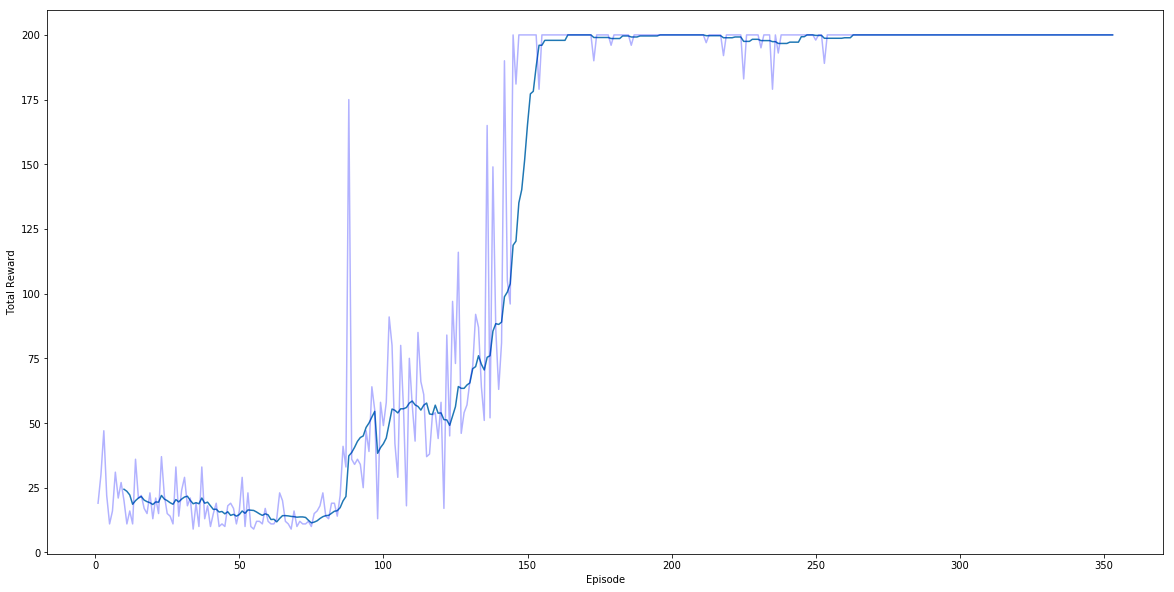

In [28]:
from matplotlib import rcParams
rcParams["figure.figsize"] = 20, 10
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

eps, rews = np.array(training_rewards).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='blue', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

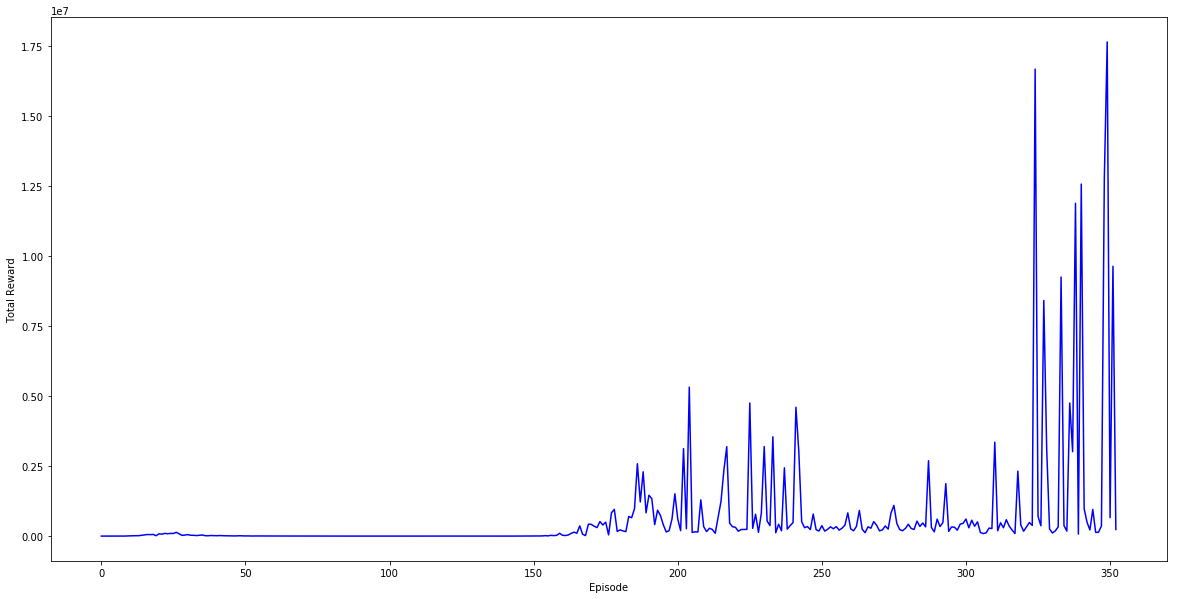

In [29]:
eps, loss = np.array(training_loss).T
plt.plot(loss, color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()